In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
! wget https://raw.githubusercontent.com/mithupriya/cnn/master/cnn_utils.py

--2019-09-02 14:23:59--  https://raw.githubusercontent.com/mithupriya/cnn/master/cnn_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5125 (5.0K) [text/plain]
Saving to: ‘cnn_utils.py’

cnn_utils.py        100%[===================>]   5.00K  --.-KB/s    in 0s      

2019-09-02 14:23:59 (66.1 MB/s) - ‘cnn_utils.py’ saved [5125/5125]



In [3]:
import keras
import numpy as np
import cnn_utils as utils
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras import regularizers, optimizers
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
np.random.seed(42)

%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 50
INPUT_SHAPE = (32, 32, 3)
WEIGHT_DECAY = 1e-4
KFOLD_WEIGHT_PATH=r'cnn_cifar10_weights_{epoch:02d}_{val_acc:.2f}.hdf5'

In [5]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

# for evaluation
TOP_N = 1

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255.
x_test = x_test/255.

170500096/170498071 [==============================] - 4s 0us/step


In [7]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [8]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [9]:
%%capture
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=INPUT_SHAPE))

#model.add(Conv2D(32, (3,3), padding='same', 
               # kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
               # activation='relu'))

#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [10]:
model .summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1843328   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,845,066
Trainable params: 1,845,066
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [12]:
early_stop_callback = [EarlyStopping(monitor='val_loss', 
                                     patience=10, verbose=0),
                       ModelCheckpoint(KFOLD_WEIGHT_PATH, 
                                       monitor='val_loss', 
                                       save_best_only=True, 
                                       verbose=0),
                      ]

In [13]:
history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=early_stop_callback)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 7s 156us/step - loss: 2.1046 - acc: 0.2299 - val_loss: 1.7182 - val_acc: 0.3936
Epoch 2/50
45000/45000 [==============================] - 3s 56us/step - loss: 1.7168 - acc: 0.3781 - val_loss: 1.5939 - val_acc: 0.4376
Epoch 3/50
45000/45000 [==============================] - 3s 57us/step - loss: 1.5465 - acc: 0.4480 - val_loss: 1.4398 - val_acc: 0.4988
Epoch 4/50
45000/45000 [==============================] - 3s 57us/step - loss: 1.4421 - acc: 0.4876 - val_loss: 1.3092 - val_acc: 0.5442
Epoch 5/50
45000/45000 [==============================] - 2s 55us/step - loss: 1.3622 - acc: 0.5154 - val_loss: 1.2711 - val_acc: 0.5628
Epoch 6/50
45000/45000 [==============================] - 3s 57us/step - loss: 1.3104 - acc: 0.5362 - val_loss: 1.2885 - val_acc: 0.5532
Epoch 7/50
45000/45000 [==============================] - 3s 56us/step - loss: 1.2645 - acc: 0.5529 - val_loss: 1.2320 - val_acc

In [14]:
model.save(filepath=r'cnn_cifar10.h5')

In [15]:
score = model.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 65us/step


In [16]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3966553577423095
Test accuracy: 0.593


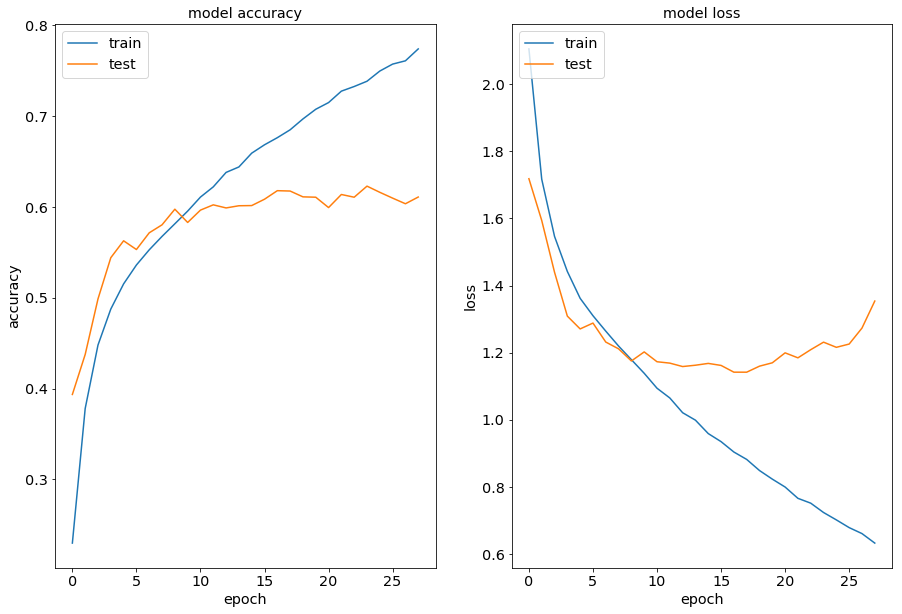

In [17]:
plt.figure(1,figsize=(15,10))  

# summarize history for accuracy  

plt.subplot(121)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(122)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

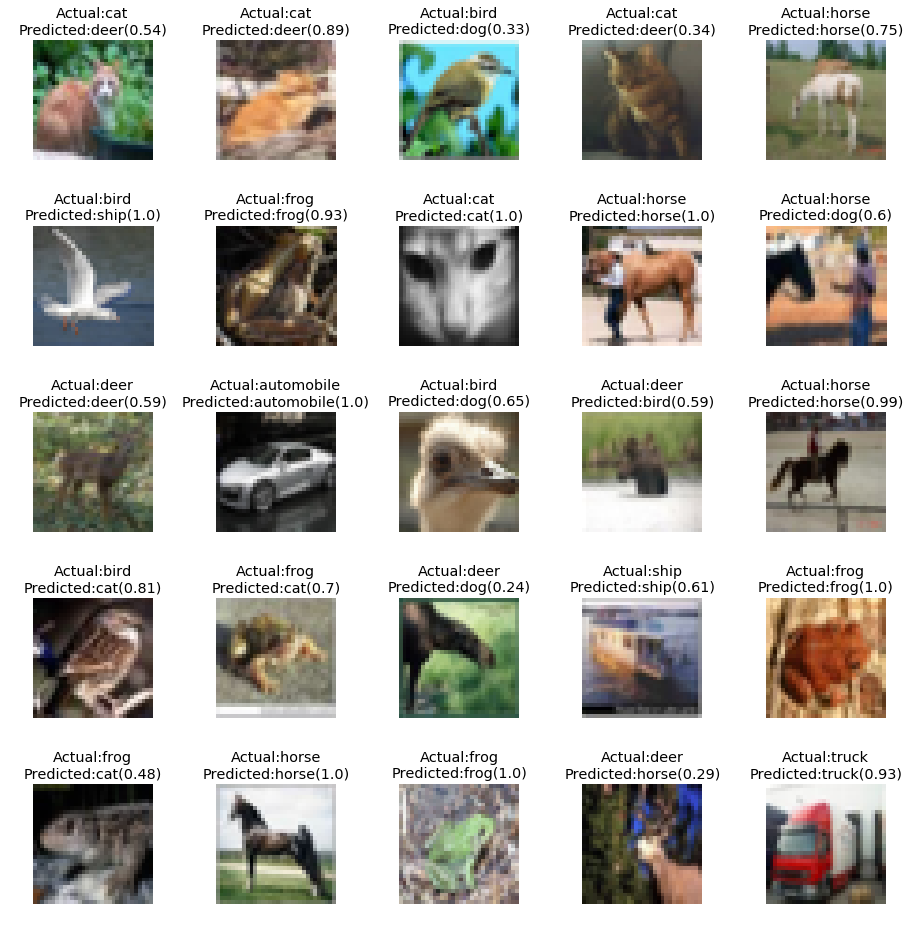

In [18]:
utils.plot_predictions(model=model,dataset=x_test,
                       dataset_labels=y_test,
                       label_dict=label_dict,
                       batch_size=25,
                       grid_height=5,
                       grid_width=5)

----- activations -----
(1, 30, 30, 16)
(1, 14400)
(1, 128)
(1, 128)
(1, 10)
Displaying activation map 0


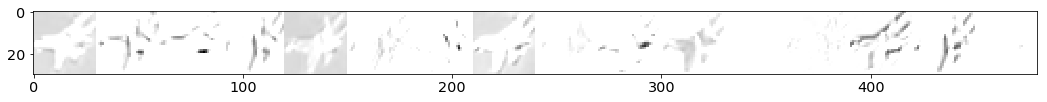

Displaying activation map 1


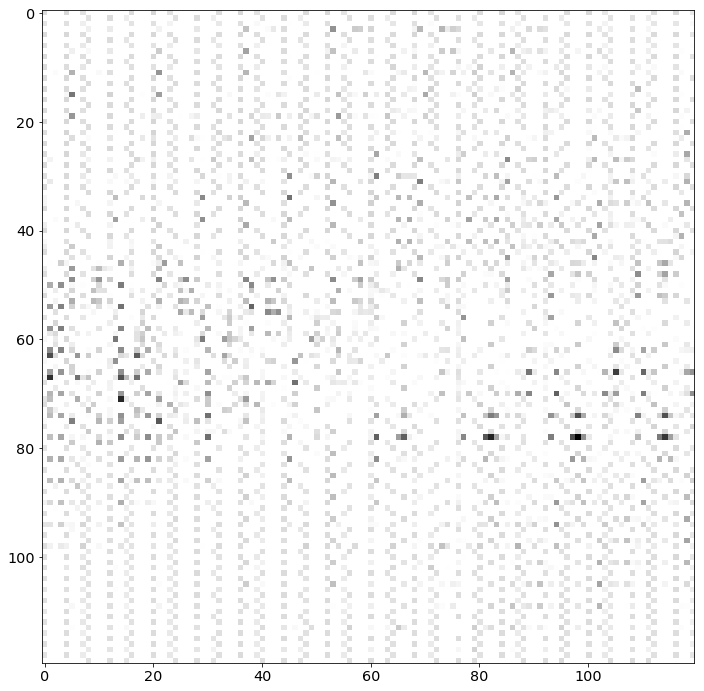

Displaying activation map 2


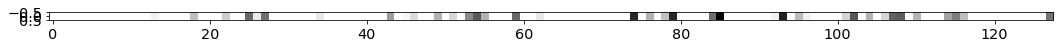

Displaying activation map 3


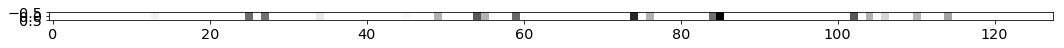

Displaying activation map 4


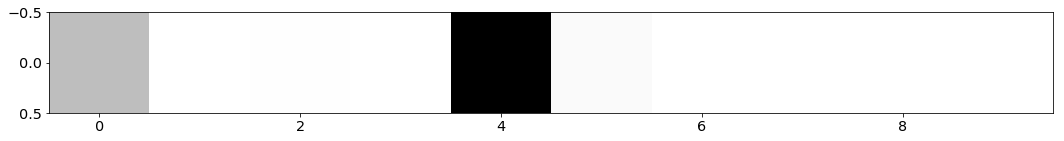

In [19]:
test_image_idx = 10
activations = utils.get_activations(model, x_test[test_image_idx].reshape(1,32,32,3))
utils.display_activations(activations)